# Project : Building an Image Classifier
### Aditi Tripathi, 2017



## Step1: Load the Data
This notebook contains an upgraded implementation of LeNet architecture to train a convolutional neural net to detect and classify images from CIFAR-10 Dataset. The CNN is implemented using TensorFlow. The images used are from [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# We can use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

CIFAR-10 Dataset: 171MB [00:20, 8.31MB/s]                              


All files found!


## Dataset Summary and Exploration
The dataset is broken into batches to prevent the machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

## Visualization
The `batch_id` is the id for a batch (1-5) given below. The `sample_id` is the id for a image and label pair in the batch.



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 5:
Image - Min Value: 0 Max Value: 252
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


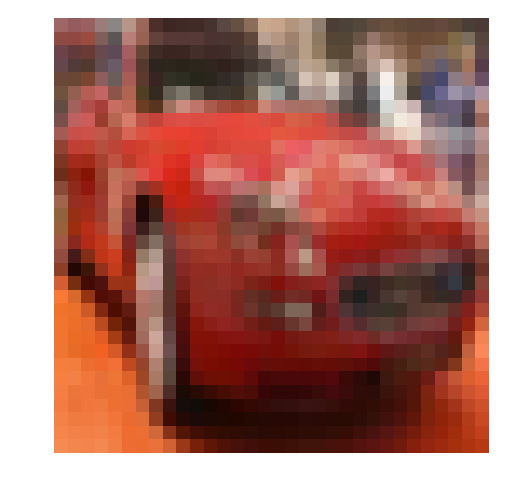

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 5
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## Implementing Preprocess Functions
### Normalization
Normalization is an important part of pre-processing data so that everything is on a relative scale. For RGB images, pixel values range from 0 to 255 and are thus already normalized. However, we can apply further normalization to scale the values from 0 to 1 or -1 to 1. When possible, it's best to avoid large numbers because smaller numbers are both faster and more computationally stable.

In [4]:
def normalize(x):
    """
    Normalizing a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    array = np.array(x)/255
    #print(array)
    return(array)



tests.test_normalize(normalize)

Tests Passed


### One-hot encoding
It is a way of representing the labels mathemtically. It is a vector as long as there are number of classes. In the vector, the correct label takes up the value '1' while rest all take '0' value.

In [31]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Returns a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
 
   # a = set(x)
   # print(a)
    l=len(x)
    one_hot = np.zeros(shape=[l,10])
   # print(one_hot)
    
    for i in range(l):
       # print(i)
        one_hot[i,x[i]] = 1
        #print(one_hot[i,:])
        
    return(one_hot)


tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### Preprocessing all the data and saving it
Running the code cell below preprocesses all the CIFAR-10 data and saves it to file. The code below uses 10% of the training data for validation.

In [32]:
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# First Check Point
The preprocessed data has been saved to disk.

In [33]:
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## Building the network
For the neural network, I've build each layer into a function.Instead of using the TF Layers version of the `conv2d` class, [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d), I would be using the TF Neural Network version of `conv2d`, [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d). 

Let's begin!

### Input
The neural network needs to read the image data, one-hot encoded labels, and dropout keep probability.The following steps will be implemented for the same:
* `neural_net_image_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `image_shape` with batch size set to `None`.
 * Name the TensorFlow placeholder "x" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* `neural_net_label_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * Set the shape using `n_classes` with batch size set to `None`.
 * Name the TensorFlow placeholder "y" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).
* `neural_net_keep_prob_input`
 * Return a [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) for dropout keep probability.
 * Name the TensorFlow placeholder "keep_prob" using the TensorFlow `name` parameter in the [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder).

These names will be used at the end of the project to load the saved model.

Note: `None` for shapes in TensorFlow allow for a dynamic size.

In [34]:
import tensorflow as tf

def neural_net_image_input(image_shape):
   
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32, shape =[None, image_shape[0],image_shape[1],image_shape[2]], name='x')
    return (input_image)


def neural_net_label_input(n_classes):
  
    # TODO: Implement Function
    label = tf.placeholder(tf.float32, shape=[None, n_classes], name= "y")
    return (label)


def neural_net_keep_prob_input():
   
    # TODO: Implement Function
    keep_prob = tf.placeholder(tf.float32,name="keep_prob")
    return (keep_prob)


tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


## Convolutional Neural Network Architecture
The architecture used in this CNN is extremely similiar to the LeNet architecture that was implemented in the Udacity LeNet lab. A difference between the original LeNet architecture from 1989 and the one provided, is that a max pooling function has been applied rather than Yann LeCun's original subsampling function.

In addition, I added two additional processes to the function to help combat overfitting. The first is applying dropout. Dropout applies a Bernoulli distribution to activations (i.e. the values being passed) during the feed-forward phase - essentially zeroing values randomly by $p$, where $p$ is the probabilty the activation will be passed forward successfully. By applying dropout, the network is forced to confirm the values it produces again and again, so that anything that persists is a very generalized signal and not "training-sample-specific" noise.
During training, I set $p = 0.5$, which I believe is rather high/aggressive, but I felt that there was ample amount of training data and I also used 150 epochs to ensure enough feed-forward phases that the high dropout would not dramatically alter my logits. During evaluation of the test samples, the dropout keep rate

Lastly, I applied L2 regularization to my Cross Entropy error when updating my weights. L2 regularization is used to penalize large errors. By doing this, we prevent our weights from changing too much, too quickly and overfitting our training sample. I used a L2 "strength" of $1E-6$ and found that value in the Amazon Web Services.

Model Parameters
Epochs: 15
Batch size: 128
Learning rate: 0.001
Truncated normal mean: 0.0
Truncated normal standard deviation: 0.1
Dropout keep rate: 0.8
L2 regularization strength: 1E-6
Loss optimization algorithm: Adam

All of these values were chosen as "standard operating procedure" based off the recommendations given in the coursework. The exception to that is the Adam algorithm. I decided to use Adam instead of stochastic gradient descent. By maintaining a moving average of the gradients, Adam is essentially using the idea of momentum to help the gradient descent avoid local minima. What is results in is a larger step size at the cost of taking up much more memory (there are significantly more parameters to store). The advantages of momentum are discussed in this paper in section 3.1. The paper explicitly states the liklihood that taking momentum into account (i.e. using Adam) may not produce better results for extremely large training samples. Given the size of the sample in this project, I thought it was appropriate to implement.


In [37]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Applying convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    #print (conv_ksize)
    #print(conv_num_outputs)
    #print (conv_strides)
    #print (pool_ksize)
    #print (pool_strides)
    #xxx= x_tensor.get_shape()
    #print(xxx)
    x_shape = (x_tensor.get_shape().as_list())

    #print (x_tensor.get_shape().as_list())
    weight = tf.Variable(tf.truncated_normal([conv_ksize[0],conv_ksize[1],x_shape[3],conv_num_outputs],mean=0.0, stddev=0.05))
    bias = tf.Variable(tf.zeros(conv_num_outputs))

    # Apply Convolution(alternative way of putting conv_strides)
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1, *conv_strides, 1], padding='SAME')
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    # Apply activation function
    conv_layer = tf.nn.relu(conv_layer)
    max_pool_layer = (tf.nn.max_pool(conv_layer,ksize=[1,*pool_ksize,1],strides=[1,pool_strides[0],pool_strides[0],1],padding='SAME'))
    
    return(max_pool_layer)

tests.test_con_pool(conv2d_maxpool)

Tests Passed


### Flatten Layer
Implements the `flatten` function to change the dimension of `x_tensor` from a 4-D tensor to a 2-D tensor.  The output is in the shape (*Batch Size*, *Flattened Image Size*).

In [38]:
def flatten(x_tensor):
    """
    Flattens x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
     # TODO: Implement Function
    dim = x_tensor.get_shape().as_list()
    #print(dim)
    x_tensor = tf.reshape(x_tensor, [-1,(dim[1]*dim[2]*dim[3])])   
    #print(x_ten.get_shape().as_list())
    return(x_tensor)


tests.test_flatten(flatten)

Tests Passed


### Fully-Connected Layer


In [39]:
def fully_conn(x_tensor, num_outputs):
    """
    Applying a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    x_shapen = x_tensor.get_shape().as_list()
    #print('shape',x_shapen)
    #print(num_outputs)
    
    weightn= tf.Variable(tf.truncated_normal([x_shapen[1], num_outputs],mean=0.0, stddev=0.05))
    biasen = tf.Variable(tf.zeros([num_outputs])) 
    full_layer = tf.add(tf.matmul(x_tensor, weightn), biasen)
    full_layer = tf.nn.relu(full_layer)
    return(full_layer)



tests.test_fully_conn(fully_conn)

Tests Passed


### Output Layer

In [40]:
def output(x_tensor, num_outputs):
    """
    Applying an output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    num_features = tf.placeholder(tf.int32)
    x_shapen = x_tensor.get_shape().as_list()
    #print('shape',x_shapen)
    
    weightn= tf.Variable(tf.truncated_normal([x_shapen[1], num_outputs], mean=0.0, stddev=0.05))
    biasen = tf.Variable(tf.random_normal([num_outputs])) 
    out_layer = tf.add(tf.matmul(x_tensor, weightn), biasen)
    return(out_layer)

tests.test_output(output)

Tests Passed


### Creating Convolutional Model

In [49]:
def conv_net(x, keep_prob):
 
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    conv_num_outputs1 = 64
    conv_ksize1 = [5,5]
    conv_strides1 = [1,1] 
    pool_ksize1 = [2,2]
    pool_strides1 = [2,2]

    # Function Definition from Above:
    layer = conv2d_maxpool(x, conv_num_outputs1, conv_ksize1, conv_strides1, pool_ksize1, pool_strides1)
    layer = tf.nn.dropout(layer,keep_prob=keep_prob)
    #2layer
    conv_num_outputs2 = 100
    conv_ksize2 = [4,4]
    conv_strides2 = [1,1]
    pool_ksize2 = [2,2]
    pool_strides2 = [2,2]
    
    # conv2d & maxpool layer
    layer = conv2d_maxpool(layer,conv_num_outputs2, conv_ksize2, conv_strides2, pool_ksize2, pool_strides2)

    
    #3layer
    conv_num_outputs3 = 16
    conv_ksize3 = [2,2]
    conv_strides3 = [1,1]
    pool_ksize3 = [2,2]
    pool_strides3 = [2,2]
    
    # conv2d & maxpool layer
    layer = conv2d_maxpool(layer,conv_num_outputs3, conv_ksize3, conv_strides3, pool_ksize3, pool_strides3)
    layer = tf.nn.dropout(layer,keep_prob=keep_prob)

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    flat1 = flatten(layer)
    

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    for i in range(2):
        full_1 = fully_conn(flat1,1000)
    
    
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    out = output(full_1, 10)
    
    
    # TODO: return output
    return (out)
   
##############################
## Building the Neural Network ##
##############################

# Removing previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Naming logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

Neural Network Built!


## Train the Neural Network
### Single Optimization


In [50]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch, keep_prob: keep_probability})
    pass



tests.test_train_nn(train_neural_network)

Tests Passed


In [51]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    # TODO: Implement Function
    loss = session.run(cost, feed_dict={x:feature_batch, y:label_batch, keep_prob:1.0})
    val_accuracy = session.run(accuracy, feed_dict={x:valid_features , y:valid_labels, keep_prob:1.0})
    print('Loss:', loss)
    print('Validation Accuracy:', val_accuracy)
    pass

### Hyperparameters
Tune the following parameters:
* Set `epochs` to the number of iterations until the network stops learning or start overfitting
* Set `batch_size` to the highest number that your machine has memory for.  Most people set them to common sizes of memory:
 * 64
 * 128
 * 256
 * ...
* Set `keep_probability` to the probability of keeping a node using dropout

In [52]:
# TODO: Tune Parameters
epochs = 15
batch_size = 128
keep_probability = 0.8

### Training on a Single CIFAR-10 Batch
Instead of training the neural network on all the CIFAR-10 batches of data, I've used a single batch. This saves time while iteration on the model to get a better accuracy.  Once the final validation accuracy is 50% or greater, the model is run on all the data in the next section.

In [53]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.03101
Validation Accuracy: 0.2986
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.85768
Validation Accuracy: 0.3642
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.69231
Validation Accuracy: 0.428
Epoch  4, CIFAR-10 Batch 1:  Loss: 1.61021
Validation Accuracy: 0.4592
Epoch  5, CIFAR-10 Batch 1:  Loss: 1.48637
Validation Accuracy: 0.4776
Epoch  6, CIFAR-10 Batch 1:  Loss: 1.32357
Validation Accuracy: 0.4968
Epoch  7, CIFAR-10 Batch 1:  Loss: 1.24206
Validation Accuracy: 0.5216
Epoch  8, CIFAR-10 Batch 1:  Loss: 1.18865
Validation Accuracy: 0.5224
Epoch  9, CIFAR-10 Batch 1:  Loss: 1.04969
Validation Accuracy: 0.5364
Epoch 10, CIFAR-10 Batch 1:  Loss: 0.925635
Validation Accuracy: 0.559
Epoch 11, CIFAR-10 Batch 1:  Loss: 0.879737
Validation Accuracy: 0.54
Epoch 12, CIFAR-10 Batch 1:  Loss: 0.719629
Validation Accuracy: 0.5648
Epoch 13, CIFAR-10 Batch 1:  Loss: 0.680447
Validation Accuracy: 0.5664
Epoch 14, CIFAR-10 Batch 1:  Loss:

### Fully Train the Model
Now that we've got a good accuracy of 57.3% with a single CIFAR-10 batch, we shall run it with all five batches.

In [54]:

save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss: 2.09393
Validation Accuracy: 0.3154
Epoch  1, CIFAR-10 Batch 2:  Loss: 1.69916
Validation Accuracy: 0.3914
Epoch  1, CIFAR-10 Batch 3:  Loss: 1.47476
Validation Accuracy: 0.4316
Epoch  1, CIFAR-10 Batch 4:  Loss: 1.48949
Validation Accuracy: 0.478
Epoch  1, CIFAR-10 Batch 5:  Loss: 1.452
Validation Accuracy: 0.4966
Epoch  2, CIFAR-10 Batch 1:  Loss: 1.51731
Validation Accuracy: 0.512
Epoch  2, CIFAR-10 Batch 2:  Loss: 1.24312
Validation Accuracy: 0.4884
Epoch  2, CIFAR-10 Batch 3:  Loss: 1.03218
Validation Accuracy: 0.5512
Epoch  2, CIFAR-10 Batch 4:  Loss: 1.13365
Validation Accuracy: 0.5654
Epoch  2, CIFAR-10 Batch 5:  Loss: 1.26576
Validation Accuracy: 0.5712
Epoch  3, CIFAR-10 Batch 1:  Loss: 1.15753
Validation Accuracy: 0.5608
Epoch  3, CIFAR-10 Batch 2:  Loss: 1.01034
Validation Accuracy: 0.5534
Epoch  3, CIFAR-10 Batch 3:  Loss: 0.898519
Validation Accuracy: 0.6022
Epoch  3, CIFAR-10 Batch 4:  Loss: 0.93117
Validation Accuracy: 0.61

# Checkpoint
The model has been saved to disk.
## Test Model

Testing Accuracy: 0.7193433544303798



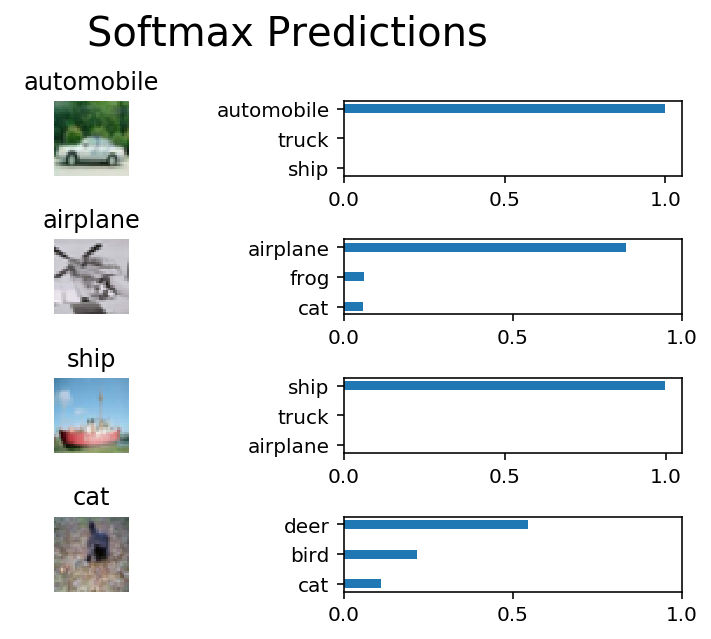

In [56]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()

## Why 50-80% Accuracy?
You might be wondering why we can't get an accuracy any higher. First things first, 50% isn't bad for a simple CNN.  Pure guessing would get us 10% accuracy given 10 classes. 

### How I approached the problem
I studied Electrical Engineering in university and am relatively new to programming. As such, I made sure to use code I had already written or had been provided during the coursework. By watching the course videos, reading on Slack, Confluence, and StackOverflow, and a healthy amount of Googling, I was able to successfully debug all of my code. Also, I ended up reading parts of several academic papers in order to understand what the code was actually doing. I found my education in mathematics particularly helpful in understanding the academic language.

Something that I was interested in both learning more about and actually implementing in my project was the inception module. It was briefly mentioned as a topic in the coursework, but there was no information about to put the idea into action. Through my research, I found that there are entire architectures built around the inception module using the TensorFlow framework. Most notably GoogLeNet and the Inception-v3. TensorFlow also has Inception-V4 available on GitHub, but I was extremely intimidated by having to use the Slim library in addition to TensorFlow and then further modifying the entire architecture to suit my needs. Ultimately, I used the resources that were readily available to me and added the processes that were mentioned during the coursework, but also included information about exactly how to implement them.
